In [1]:
import jetnet
from jetnet.datasets import JetNet
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from IPython.display import Markdown, display
import pickle
from typing import OrderedDict

plt.rcParams.update({"font.size": 16})

# Raghav's script


/home/rd804/.conda/envs/discr-metric/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rd804/.conda/envs/discr-metric/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from coffea.lookup_tools.dense_lookup import dense_lookup

In [3]:
cd ..

/home/rd804/discriminator-metric


In [4]:
truth_jets_pf, truth_jet_data = JetNet.getData(
    "g",
    data_dir="data",
    split_fraction=[1, 0, 0],
    jet_features=["pt", "eta", "mass", "num_particles"],
    particle_features=["etarel", "phirel", "ptrel"]
    )

In [5]:
mass = jetnet.utils.jet_features(truth_jets_pf[:, :, :3])["mass"]

np.random.seed(4)

bins = np.linspace(0, np.max(mass), 26)
true_mass_hist = np.histogram(mass, bins)[0]

smeared_hist = np.histogram(mass * np.random.normal(1, 0.25, size=mass.shape), bins)[0]
shifted_hist = np.histogram(mass * np.random.normal(1.1, 0.05, size=mass.shape), bins)[0]

smeared_lookup = dense_lookup(smeared_hist / true_mass_hist, bins)
shifted_lookup = dense_lookup(shifted_hist / true_mass_hist, bins)

smeared_weights = smeared_lookup(mass)
smeared_weights /= np.sum(smeared_weights)

shifted_weights = shifted_lookup(mass)
shifted_weights /= np.sum(shifted_weights)

tailcut_weights = (mass < 0.17).astype(float)
tailcut_weights /= np.sum(tailcut_weights)

dists = OrderedDict(
    [
        ("truth", (np.ones(truth_jets_pf.shape[0]) / truth_jets_pf.shape[0], "Truth")),
        ("smeared", (smeared_weights, "Smeared")),
        ("shifted", (shifted_weights, "Shifted")),
        ("tailcut", (tailcut_weights, "Removing tail")),
    ]
)

In [6]:
np.random.seed(4)

pf_dists = OrderedDict()

pf_dists["all_smeared"] = (
    truth_jets_pf * np.random.normal(1, 0.25, size=truth_jets_pf.shape),
    "Particle Features Smeared",
)
pf_dists["eta_smeared"] = (
    np.concatenate(
        (
            truth_jets_pf[..., 0:1] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 0:1].shape),
            truth_jets_pf[..., 1:],
        ),
        axis=-1,
    ),
    r"Particle $\eta^{rel}$ Smeared",
)
pf_dists["pt_smeared"] = (
    np.concatenate(
        (
            truth_jets_pf[..., :2],
            truth_jets_pf[..., 2:3] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 2:3].shape),
        ),
        axis=-1,
    ),
    r"Particle $p_T^{rel}$ Smeared",
)
pf_dists["pt_shifted"] = (
    np.concatenate(
        (
            truth_jets_pf[..., :2],
            truth_jets_pf[..., 2:3]
            * np.random.normal(0.9, 0.1, size=truth_jets_pf[..., 2:3].shape),
        ),
        axis=-1,
    ),
    r"Particle $p_T^{rel}$ Shifted",
)


In [7]:
masses = {key: jetnet.utils.jet_features(jets)["mass"] for key, (jets, _) in pf_dists.items()}

In [19]:
def plot_dists(true_feat_dist, pf_feat_dists, bins, feat_label, name, log=False, pf=False):
    fig, axes = plt.subplots(1, 2, figsize=(28, 12))

    colours = ["#3F88C5", "#990000", "#7CB518", "#FF5B00", "#142F43"]

    for ax in axes:
        _ = ax.hist(
            true_feat_dist if not pf else true_feat_dist.reshape(-1),
            bins,
            histtype="step",
            label="Truth",
            linewidth=4,
             density=True,
            color=colours[0],
        )

    for i, (weights, label) in enumerate(dists.values()):
        if label == "Truth":
            continue

        _ = axes[0].hist(
            true_feat_dist if not pf else true_feat_dist.reshape(-1),
            bins,
            weights=weights if not pf else weights.repeat(30),
            histtype="step",
            label=label,
            linewidth=2,
            linestyle="dashed",
            density=True,
            color=colours[i],
        )
        

    for ax in axes:
        ax.margins(x=0)
        ax.legend()
        ax.set_xlabel(feat_label)
        ax.set_ylabel("Probability (A.U.)")

        if log:
            ax.set_yscale("log")

In [20]:
plot_params = [
    [mass, masses, np.linspace(0, 0.22, 101), r"Jet $m/p_T$", "mass"]]

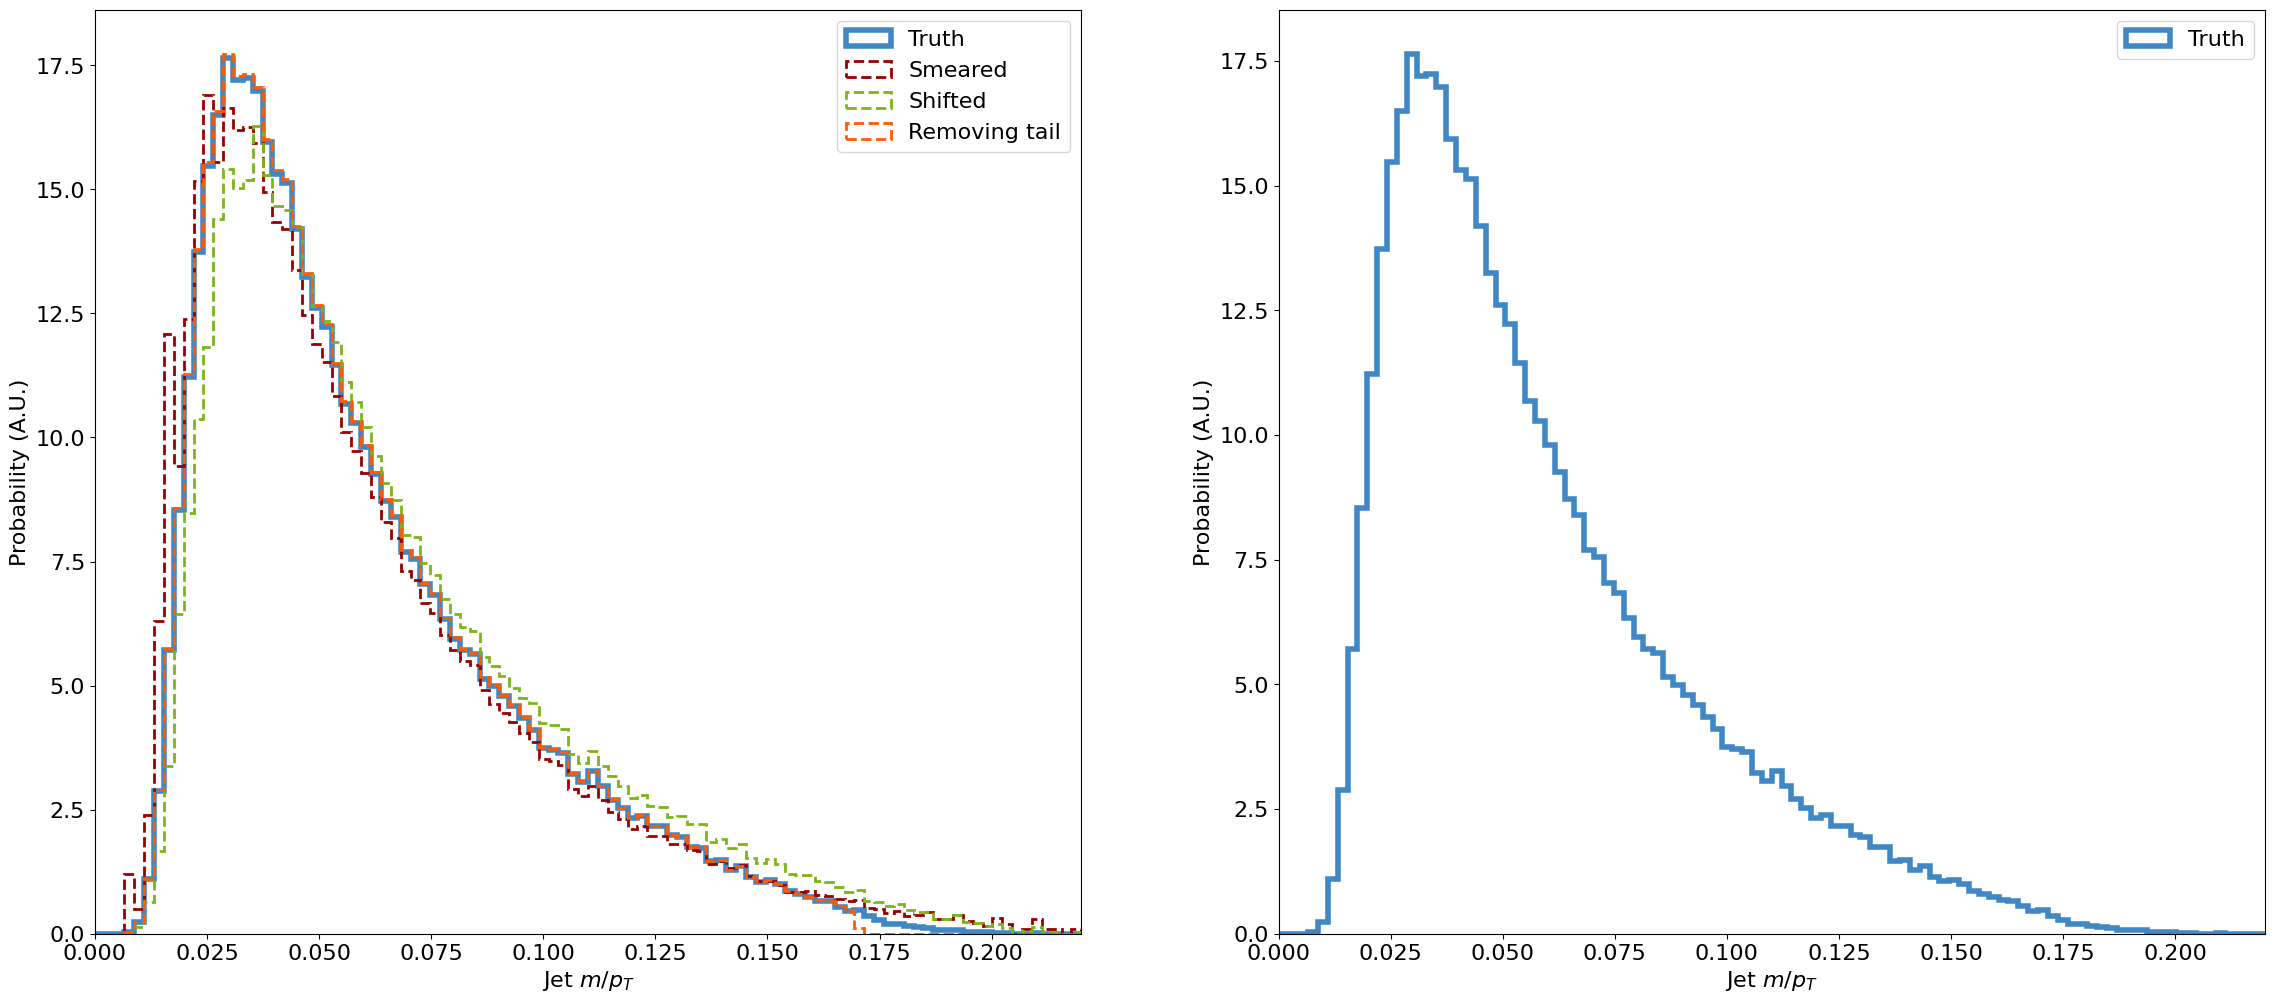

In [21]:
for params in plot_params:
    plot_dists(*params)

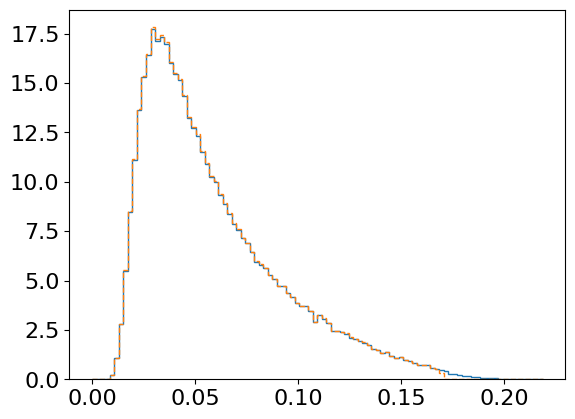

In [25]:
plt.hist(mass, bins=np.linspace(0, np.max(mass), 101), histtype="step", 
         label="Truth", linewidth=1,density=True)
plt.hist(mass, bins=np.linspace(0, np.max(mass), 101), histtype="step", 
         label="tailcut",
         weights=tailcut_weights,linewidth=1, linestyle="dashed", density=True)
plt.show()


In [6]:
num_samples = 150_000
sample_masses = OrderedDict()

np.random.seed(4)
true_inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
true_mass = mass[true_inds]

for key, (weights, _) in dists.items():
    print(key)
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples, p=weights)
    sample_masses[key] = mass[inds]
    np.save(f"data/{key}.npy", truth_jets_pf[inds])


truth
smeared
shifted
tailcut


In [7]:
my_tailcut = np.load("data/tailcut.npy")

In [8]:
raghav_tailcut = np.load("data/distorted_jets/tailcut.npy")

In [11]:
 if np.sum(raghav_tailcut - my_tailcut)==0:
    print("Success")

Success


In [10]:
dists.keys()

odict_keys(['truth', 'smeared', 'shifted', 'tailcut'])

In [32]:
np.random.seed(4)
for i in range(5):
    index = np.random.choice(np.arange(10), 5)
    print(index)

[7 5 1 8 7]
[8 2 9 7 7]
[7 9 8 4 2]
[6 4 3 0 7]
[5 5 9 6 6]
